# Week 7 - Temporal models 

## Part 4: Road traffic - Time-series imputation (with multivariate LDS)

In this part, we will specify a **multivariate** linear dynamical system (LDS) in STAN in order to do **imputation** on the freeway occupancy rates. The intuition is rather simple:
- Based on our domain knowledge and our knowledge about the problem, we know that freeway occupancy rates at nearby road segments should be highly correlated (cars don't just disappear; the must go somewhere!). Therefore, time-series observations from nearby sensors should also reflect these correlations.
- We can thus exploit these correlations and use the related time-series from nearby sensors (which probably will itself have missing observations) in order to help us do imputation on the time-series from a given sensor.

In this notebook, we will **use a multivariate LDS in order to explore these correlations and try to improve our imputations**.

The usual imports...

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
import pystan
import pystan_utils

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

The data consists of time-series of freeway occupancy rates (rows), with length $T=1008$, at 10 different consecutive sensors/detectors (columns). Although we will focus only on the data from two specific detectors as an example...

Load data:

In [3]:
# load csv
df = pd.read_csv("PeMS_sample.csv")
df.head()

,# detector400000,detector400001,detector400009,detector400010,detector400015,detector400017,detector400025,detector400026,detector400027,detector400030
0,0.0154,0.0054,0.0164,0.0079,0.0059,0.0138,0.0111,0.0156,0.0154,0.0080
1,0.0085,0.0051,0.0127,0.0062,0.0051,0.0125,0.0099,0.0175,0.0134,0.0067
2,0.0099,0.0056,0.0172,0.0068,0.0053,0.0116,0.0105,0.0157,0.0112,0.0065
3,0.0108,0.0045,0.0126,0.0072,0.0058,0.0131,0.0073,0.0146,0.0128,0.0040
4,0.0100,0.0037,0.0185,0.0048,0.0063,0.0099,0.0061,0.0157,0.0123,0.0064


Some basic data statistics:

In [4]:
print("Dataset size:", len(df))
print("General statistics:")
df.describe()

Dataset size: 1008
General statistics:


,# detector400000,detector400001,detector400009,detector400010,detector400015,detector400017,detector400025,detector400026,detector400027,detector400030
count,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.00000,1008.000000
mean,0.049489,0.044541,0.066207,0.051599,0.026812,0.047976,0.037051,0.055881,0.05583,0.049262
std,0.030016,0.047490,0.047321,0.040934,0.019402,0.052455,0.036248,0.049275,0.04192,0.042152
min,0.005300,0.000000,0.000000,0.000000,0.001900,0.002200,0.002900,0.002500,0.00150,0.001500
25%,0.027150,0.014900,0.029525,0.018000,0.013100,0.014775,0.012075,0.017950,0.01820,0.027075
50%,0.055300,0.038600,0.070500,0.046400,0.021700,0.038750,0.029000,0.051500,0.05665,0.046700
75%,0.064400,0.051900,0.088025,0.070800,0.030925,0.054125,0.045400,0.069825,0.07670,0.058925
max,0.317600,0.355000,0.393600,0.232700,0.094900,0.316900,0.197200,0.307400,0.22060,0.408100


Visualize data (part of it):

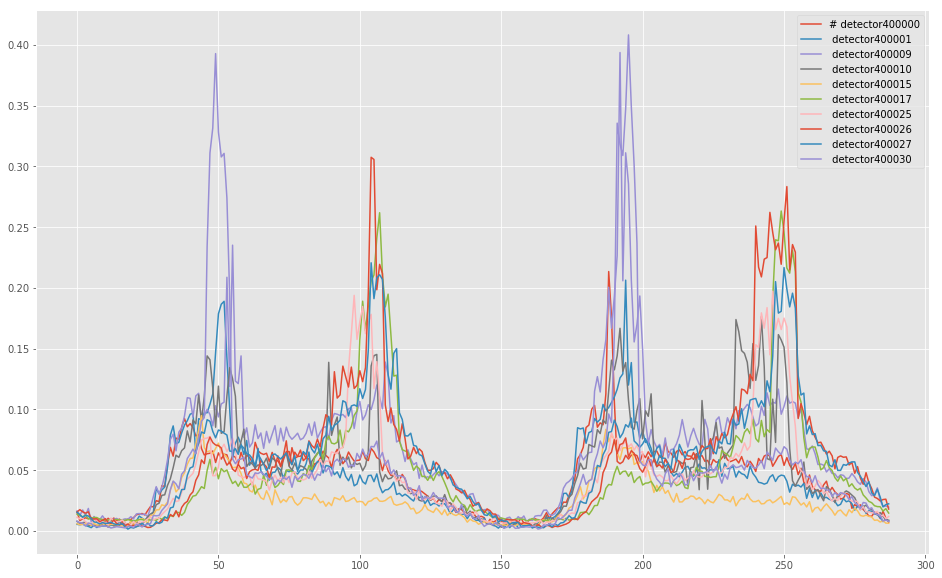

In [5]:
plt.plot(df[:(2*24*6)]) # first 2 days (2*24*6 10-minute intervals) of each of the 10 detectors
plt.legend(df.columns)

Lets now generate some articial missing data at random. To make things challenging, will consider a difficult setting were **80% of the observations are missing**. 

Notice that we save the real observations for the 80% missings, in order to evaluate the accuracy of our imputations later on.

Also, **note that both of the time-series that we will be using in this notebook have 80% of missing observations!**

In [6]:
# convert data to a matrix
y = df.as_matrix()
y = y[:(6*24*1)]
N, D = y.shape
print("N=%d, D=%d" % (N,D))

N=144, D=10


In [7]:
missing_perc = 0.8 # missing percentage

perm1 = np.random.permutation(N)
ix_mis1 = perm1[:int(missing_perc * N)] # missing indexes
ix_obs1 = perm1[int(missing_perc * N):] # observed indexes
y_mis1 = y[ix_mis1,7]
y_obs1 = y[ix_obs1,7]

perm2 = np.random.permutation(N)
ix_mis2 = perm2[:int(missing_perc * N)] # missing indexes
ix_obs2 = perm2[int(missing_perc * N):] # observed indexes
y_mis2 = y[ix_mis2,8]
y_obs2 = y[ix_obs2,8]

N_obs = len(ix_obs1)
N_mis = len(ix_mis1)
print "N_obs:", N_obs
print "N_mis:", N_mis

N_obs: 29
N_mis: 115


Lets try to implement a multivariate LDS in STAN! The model will have quite a few similaries with the one from the previous notebook (i.e. part 3), but also some significant changes.


The first thing to notice is that we will now have two time-series instead of one! You therefore should make changes accordingly.


We will model the correlations between the two series in the latent state $\textbf{z}_t$. We will assume that our latent state is 2-dimensional $\textbf{z}_t = \{z_{t,1},z_{t,2}\}$ with latent dynamics:
\begin{align}
\textbf{z}_t &\sim \mathcal{N}(\boldsymbol\beta \textbf{z}_{t-1}, \boldsymbol\Sigma)
\end{align}
And likelihoods:
\begin{align}
y_{t,1} &\sim \mathcal{N}(z_{t,1}, \sigma^2)\\
y_{t,2} &\sim \mathcal{N}(z_{t,2}, \sigma^2)
\end{align}
Or, if you prefer (equivalent!):
\begin{align}
\textbf{y}_t &\sim \mathcal{N}(\textbf{z}_t, \sigma^2 \textbf{I})
\end{align}

The key element in the simple model described above is the **covariance matrix $\boldsymbol\Sigma$**! This the object that will allow us to capture the correlations between the two time-series. We therefore need it to be a full matrix (i.e. rather than a isotropic covariance matrix of the form $\boldsymbol\Sigma = \sigma^2 \textbf{I}$)! Do you understand why?

What about the prior for $\boldsymbol\Sigma$? While the inverse-Wishart distribution is the conjugate prior for the covariance matrix of a multivariate normal distribution, it is not very well-suited to modern Bayesian computational methods. For this reason, the **LKJ prior** is recommended when modeling the covariance matrix of a multivariate normal distribution. More on that in a minute...

In STAN, the recommended approach is to decompose the covariance matrix $\boldsymbol\Sigma$ into a scale and a matrix, but we are able to do so in a more natural way based on the actual variable scales and a correlation matrix. Specifically, we define:

\begin{align}
\boldsymbol\Sigma = \mbox{diag_matrix}(\boldsymbol\tau) \, \boldsymbol\Omega \, \mbox{diag_matrix}(\boldsymbol\tau)
\end{align}

where $\mbox{diag_matrix}(\boldsymbol\tau)$ denotes a diagonal matrix with diagonal elements given by the vector $\boldsymbol\tau$. In this parameterization, $\boldsymbol\Omega$ can be regarded as a correlation matrix and $\boldsymbol\tau$ is a vector of coefficient scales.

We can define these variables in "parameters" block of STAN as follows:

corr_matrix[2] Omega;

vector<lower=0>[2] tau;

Like any other variable, we also must assign priors to $\boldsymbol\tau$ and $\boldsymbol\Omega$. The components of the scale vector $\boldsymbol\tau$ can be given any reasonable prior for scales, but we recommend something weakly informative like a half-Cauchy distribution with a small scale, such as:

\begin{align}
\boldsymbol\tau ∼ Cauchy(0, 1.0) , \, \mbox{with the constraint:} \, \boldsymbol\tau > 0
\end{align}

As for the correlation matrix $\boldsymbol\Omega$, the STAN manual recommends a LKJ prior with shape $\nu \geq 1$:

\begin{align}
\boldsymbol\Omega ∼ LKJCorr(10.0)
\end{align}

The LKJ correlation distribution is defined in Section 63.1 of the STAN's manual, but the basic idea for modeling is that as it parameter $\nu$ increases, the prior increasingly concentrates around the unit correlation matrix (i.e., favors less correlation among the components of $\textbf{z}$). At $\nu = 1$, the LKJ correlation distribution reduces to the identity distribution over correlation matrices. The LKJ prior may thus be used to control the expected amount of correlation among the values of $\textbf{z}$.

We define these priors in STAN as follows (don't forget the constraint on tau!):

tau ~ cauchy(0,1);

Omega ~ lkj_corr(10.0);     

Finally, we can define a multivariate Gaussian with parameters $\boldsymbol\mu$, $\boldsymbol\tau$ and $\boldsymbol\Omega$ using:

multi_normal(mu, quad_form_diag(Omega, tau))

Ok, after this (long) explanation, do you think you can implement in STAN the multivariate LDS described above? :-)

In [12]:
# define Stan model
model_definition = """
// TODO
"""

In [9]:
# prepare data for Stan model
data = {'N_obs': N_obs, 'N_mis': N_mis, 
        'ix_obs1': ix_obs1+1, 'ix_mis1': ix_mis1+1, 'y_obs1': y_obs1, 
        'ix_obs2': ix_obs2+1, 'ix_mis2': ix_mis2+1, 'y_obs2': y_obs2}

Compile STAN program:

In [13]:
%%time
# create Stan model object (compile Stan model)
sm = pystan.StanModel(model_code=model_definition)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_91a79189aad860f95663b9fa99c2b7ac NOW.


CPU times: user 867 ms, sys: 44 ms, total: 911 ms
Wall time: 38.5 s


Run inference using MCMC:

In [14]:
fit = sm.sampling(data=data, iter=500, chains=4, algorithm="NUTS", seed=42, verbose=True)
print(fit)

/Users/fmpr/anaconda/envs/stan/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Inference for Stan model: anon_model_91a79189aad860f95663b9fa99c2b7ac.
4 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0,0]           0.98  9.6e-4   0.02   0.94   0.97   0.98   0.99   1.01    339   1.01
beta[1,0]           0.99  1.4e-3   0.01   0.97   0.99   0.99    1.0   1.01    107   1.08
L_corr_noise[0,0]    1.0     0.0    0.0    1.0    1.0    1.0    1.0    1.0   1000    nan
L_corr_noise[1,0]   0.29    0.02   0.17  -0.09    0.2   0.33    0.4   0.59     54   1.07
L_corr_noise[0,1]   0.29    0.02   0.17  -0.09    0.2   0.33    0.4   0.59     54   1.07
L_corr_noise[1,1]    1.0 3.4e-188.5e-17    1.0    1.0    1.0    1.0    1.0    611    nan
tau[0]              0.02  2.0e-4 2.1e-3   0.01   0.01   0.02   0.02   0.02    120   1.04
tau[1]            7.4e-3  6.1e-4 2.1e-3 5.3e-3 6.4e-3 7.2e-3 7.8e-3   0.01     12   1.19
sigma        

(Ok, looking at the diagnostic statistics (Rhat, traceplots below, etc.), it is clear that we should have run our MCMC chains for a longer period (i.e. more iterations), but for practical reasons, in this case we will be ok with "imperfect" diagnostics. But, in general, as a rule of thumb, **you should always make sure that you get good diagnostics!**)

Extract samples and plot posteriors over some of the latent variables (parameters): tau and sigma

In [15]:
samples = fit.extract(permuted=True)  # return a dictionary of arrays

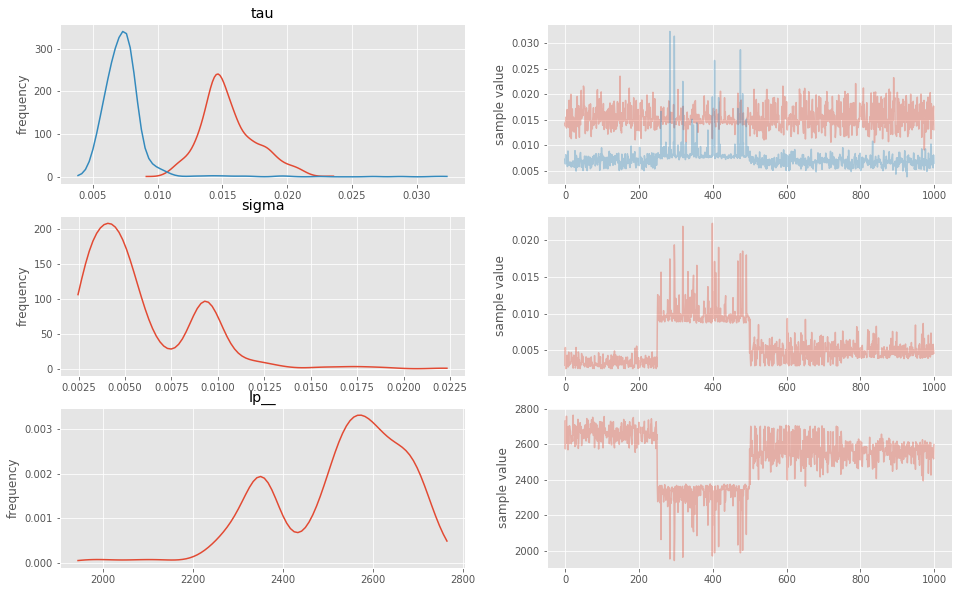

In [16]:
fit.plot(["tau","sigma","lp__"])
plt.show()

Compute mean and standard devitions for the imputed values of the time-series and visualize them (in comparison with the corresponding true values):

In [19]:
# get mean and standard devitions for predictions
y_hat = samples["y_mis1"].mean(axis=0)
y_std = samples["y_mis1"].std(axis=0)

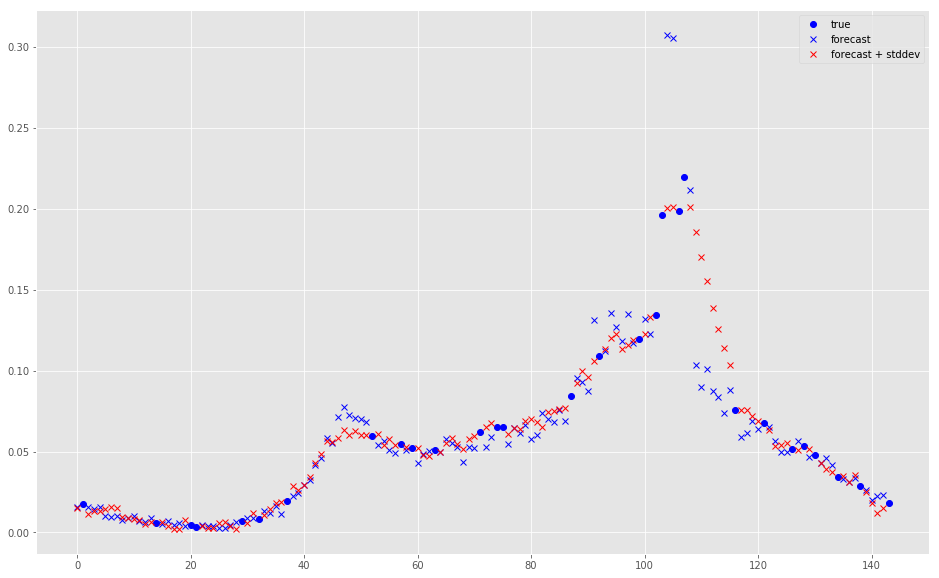

In [20]:
plt.plot(ix_obs1, y_obs1, "bo")
plt.plot(ix_mis1, y_mis1, "bx")
plt.plot(ix_mis1, y_hat, "rx")
#plt.plot(ix_mis, y_hat + y_std, "r--")
#plt.plot(ix_mis, y_hat - y_std, "r--")

Compute error statistics of the model's imputations:

In [21]:
def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

In [22]:
corr, mae, rae, rmse, r2 = compute_error(y_mis1, y_hat)
print("CorrCoef: %.3f\nMAE: %.5f\nRMSE: %.5f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.912
MAE: 0.00961
RMSE: 0.02073
R2: 0.830


Did you get a better result than with univariate LDS model from notebook 3? Compare the error statistics and the plots. You should have obtained a better result using the multivariate LDS. We could probably improve these results even further by:
- Consider even more correlated time-series (instead of just 2) and model their correlations in the multivariate LDS;
- Building more complex temporal dynamics, e.g. with higher order dependencies, with high dimensional latent states, different distributions, etc.